In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator
#import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_squared_log_error, explained_variance_score
from sklearn.model_selection import learning_curve, validation_curve

from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras import backend
import os
from pandas import DataFrame
from numpy import concatenate

import tensorflow as tf
print("Tensorflow:", tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, BatchNormalization, Activation, Dropout, LeakyReLU, PReLU
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import datetime
from math import sqrt
from sklearn.model_selection import TimeSeriesSplit, LeaveOneOut, KFold
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import f1_score, mean_squared_log_error
import statistics
from sklearn.datasets import load_digits
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

Tensorflow: 2.0.0-alpha0


Using TensorFlow backend.


In [2]:
np.random.seed(7)

In [3]:
#************************RPE (Relative Percentage Error)*****************************
def rpe(y_true, y_pred):
    return backend.abs((y_pred - y_true)/y_true * 100)

In [4]:
#*********************** (Root Mean Sequare Error metrics)********************************
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [5]:
#*******************************Load data***************************************
data_raw = []
for week in range(1, 11):
    week_data = pd.read_csv('../Paper1/TUCspam{}.csv'.format(week)).values
    data_raw.append(week_data)

In [6]:
data = np.array(data_raw)
data.shape

(10,)

# Time series split

In [7]:
X = [1,2,3,4,5,6,7,8,9,10]

splits = TimeSeriesSplit(n_splits=9)
for train, test in splits.split(X):
    print('Train: {} \t Test: {}'.format(train, test))

Train: [0] 	 Test: [1]
Train: [0 1] 	 Test: [2]
Train: [0 1 2] 	 Test: [3]
Train: [0 1 2 3] 	 Test: [4]
Train: [0 1 2 3 4] 	 Test: [5]
Train: [0 1 2 3 4 5] 	 Test: [6]
Train: [0 1 2 3 4 5 6] 	 Test: [7]
Train: [0 1 2 3 4 5 6 7] 	 Test: [8]
Train: [0 1 2 3 4 5 6 7 8] 	 Test: [9]


In [8]:
index = 1
splits = TimeSeriesSplit(n_splits=9)
for train_index, test_index in splits.split(data):
    data_train= data[train_index]
    data_test = data [test_index]
    data_train = np.concatenate(data_train)
    data_test = np.concatenate (data_test)
    print (data_train.shape, data_test.shape)

(428, 1) (669, 1)
(1097, 1) (349, 1)
(1446, 1) (480, 1)
(1926, 1) (341, 1)
(2267, 1) (572, 1)
(2839, 1) (434, 1)
(3273, 1) (511, 1)
(3784, 1) (349, 1)
(4133, 1) (421, 1)


In [9]:
#****************************Create lagged time series dataset*******************
look_back=3

def prepare_seq2seq_data(dataset, look_back=1):

    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [10]:
data_train= data_train.astype('float32')
data_test = data_test.astype('float32')
    
scaler = MinMaxScaler (feature_range= (-1,1)) 
train_scaled = scaler.fit_transform (data_train)
test_scaled = scaler.transform(data_test)

In [11]:
look_back = 3
train_X, train_y = prepare_seq2seq_data(train_scaled, look_back)
test_X, test_y = prepare_seq2seq_data(test_scaled, look_back)

In [12]:
train_X = np.reshape(train_X,(train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X,(test_X.shape[0], test_X.shape[1], 1))
print (train_X.shape,train_y.shape, test_X.shape, test_y.shape)

(4129, 3, 1) (4129,) (417, 3, 1) (417,)


In [13]:
#************************RPE (Relative Percentage Error)*****************************

def rpe(y_true, y_pred):
    return backend.abs((y_pred - y_true)/y_true * 100)

In [14]:
def get_score(model, train_X, test_X,train_y, test_y):
    model.fit(train_X, train_y)
    return model.score(test_X, test_y)

In [15]:
error_rnn=[]
bias_rnn= []
error_lstm=[]
bias_lstm=[]
error_gru=[]
bias_gru=[]
variance_all=[]

n_splits=9


splits = TimeSeriesSplit(n_splits=9)
for train_index, test_index in splits.split(data):
    
    
    #RNN model
    
    model_rnn = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(128, input_shape=(look_back, 1)),
    tf.keras.layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.Adam(lr=0.0001)
    model_rnn.compile(loss='mse', optimizer=optimizer, metrics=[rpe, rmse])
     # fit the model or train on data
    model_rnn.fit (train_X, train_y)
    # test score
    testPredict_rnn = model_rnn.predict(test_X)
    error_rnn.append(mean_squared_error(test_y, testPredict_rnn, multioutput= 'uniform_average'))
    print()
    # Bias
    bias_rnn.append(sum(error_rnn)/(len(error_rnn)-1))
    #bias1.append((sum(error1)/(len(error1)-1))**2)
    
    #Variance
    variance_rnn=[]
    for i in error_rnn:
        a = np.square(i -np.mean(error_rnn))
        variance_rnn.append(a)
    variance_all.append((sum(variance_rnn))/(n_splits-1))


   #LSTM model
    model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(look_back, 1)),
    tf.keras.layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.Adam(lr=0.0001)
    model_lstm.compile(loss='mse', optimizer=optimizer, metrics=[rpe, rmse])
    # fit the model or train on data
    model_lstm.fit (train_X, train_y)
    # test score
    testPredict_lstm = model_lstm.predict(test_X)
    error_lstm.append(mean_squared_error(test_y, testPredict_lstm, multioutput= 'uniform_average'))
    print()
    # Bias
    bias_lstm.append(sum(error_lstm)/(len(error_lstm)-1))
    #bias1.append((sum(error1)/(len(error1)-1))**2) 
    
    #Variance
    variance_lstm=[]
    for i in error_lstm:
        a = np.square(i -np.mean(error_lstm))
        variance_lstm.append(a)
    variance_all.append((sum(variance_lstm))/(n_splits-1))
    
    
     #GRU model
    model_gru = tf.keras.Sequential([
    tf.keras.layers.GRU(128, input_shape=(look_back, 1)),
    tf.keras.layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.Adam(lr=0.0001)
    model_gru.compile(loss='mse', optimizer=optimizer, metrics=[rpe, rmse])
    # fit the model or train on data
    model_gru.fit (train_X, train_y)
    # test score
    testPredict_gru = model_gru.predict(test_X)
    error_gru.append(mean_squared_error(test_y, testPredict_gru, multioutput= 'uniform_average'))
    print()
    # Bias
    bias_gru.append(sum(error_gru)/(len(error_gru)-1))
    #bias1.append((sum(error1)/(len(error1)-1))**2) 
    
    #Variance
    variance_gru=[]
    for i in error_gru:
        a = np.square(i -np.mean(error_gru))
        variance_gru.append(a)
    variance_all.append((sum(variance_gru))/(n_splits-1))

4129/4129 [==============================] - 0s 101us/sample - loss: 0.0244 - rpe: 13.9452 - rmse: 0.0719



c:\users\31950627\kerast\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars


4129/4129 [==============================] - 1s 149us/sample - loss: 0.4463 - rpe: 67.6518 - rmse: 0.6477



c:\users\31950627\kerast\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


4129/4129 [==============================] - 1s 151us/sample - loss: 0.5075 - rpe: 68.8988 - rmse: 0.6703



c:\users\31950627\kerast\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in double_scalars


4129/4129 [==============================] - 0s 97us/sample - loss: 0.2113 - rpe: 32.4968 - rmse: 0.2555

4129/4129 [==============================] - 1s 148us/sample - loss: 0.5530 - rpe: 74.6176 - rmse: 0.7264

4129/4129 [==============================] - 1s 151us/sample - loss: 0.4092 - rpe: 63.2193 - rmse: 0.5896

4129/4129 [==============================] - 0s 97us/sample - loss: 0.0309 - rpe: 14.6189 - rmse: 0.0831

4129/4129 [==============================] - 1s 158us/sample - loss: 0.4670 - rpe: 68.6927 - rmse: 0.6605

4129/4129 [==============================] - 1s 159us/sample - loss: 0.4346 - rpe: 63.7753 - rmse: 0.6164

4129/4129 [==============================] - 0s 94us/sample - loss: 0.0833 - rpe: 20.9948 - rmse: 0.1487

4129/4129 [==============================] - 1s 165us/sample - loss: 0.3910 - rpe: 62.8432 - rmse: 0.6023

4129/4129 [==============================] - 1s 152us/sample - loss: 0.4385 - rpe: 66.0616 - rmse: 0.6200

4129/4129 [=============================

# Bias and variance 

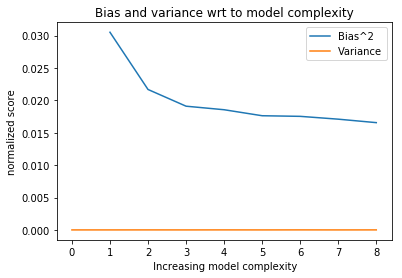

In [31]:
b = plt.plot( bias_rnn)
v= plt.plot( variance_rnn)
plt.title('Bias and variance wrt to model complexity')
plt.xlabel(' Increasing model complexity')
plt.ylabel('normalized score')
plt.legend((b[0], v[0]), ('Bias^2', 'Variance'))
plt.show()

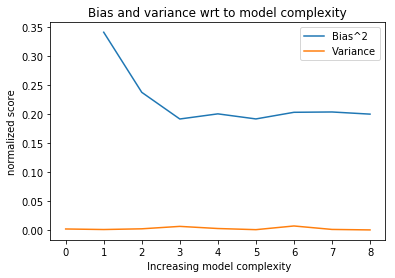

In [30]:
b = plt.plot( bias_lstm )
v= plt.plot( variance_lstm)

plt.title('Bias and variance wrt to model complexity')
plt.xlabel(' Increasing model complexity')
plt.ylabel('normalized score')
plt.legend((b[0], v[0]), ('Bias^2', 'Variance'))
plt.show()

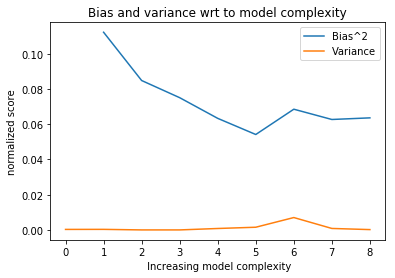

In [29]:
b = plt.plot( bias_gru)
v= plt.plot( variance_gru)
plt.title('Bias and variance wrt to model complexity')
plt.xlabel(' Increasing model complexity')
plt.ylabel('normalized score')
plt.legend((b[0], v[0]), ('Bias^2', 'Variance'))
plt.show()